In [128]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
seed: int = sum(map(ord, "power_sample_size"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

<Axes: >

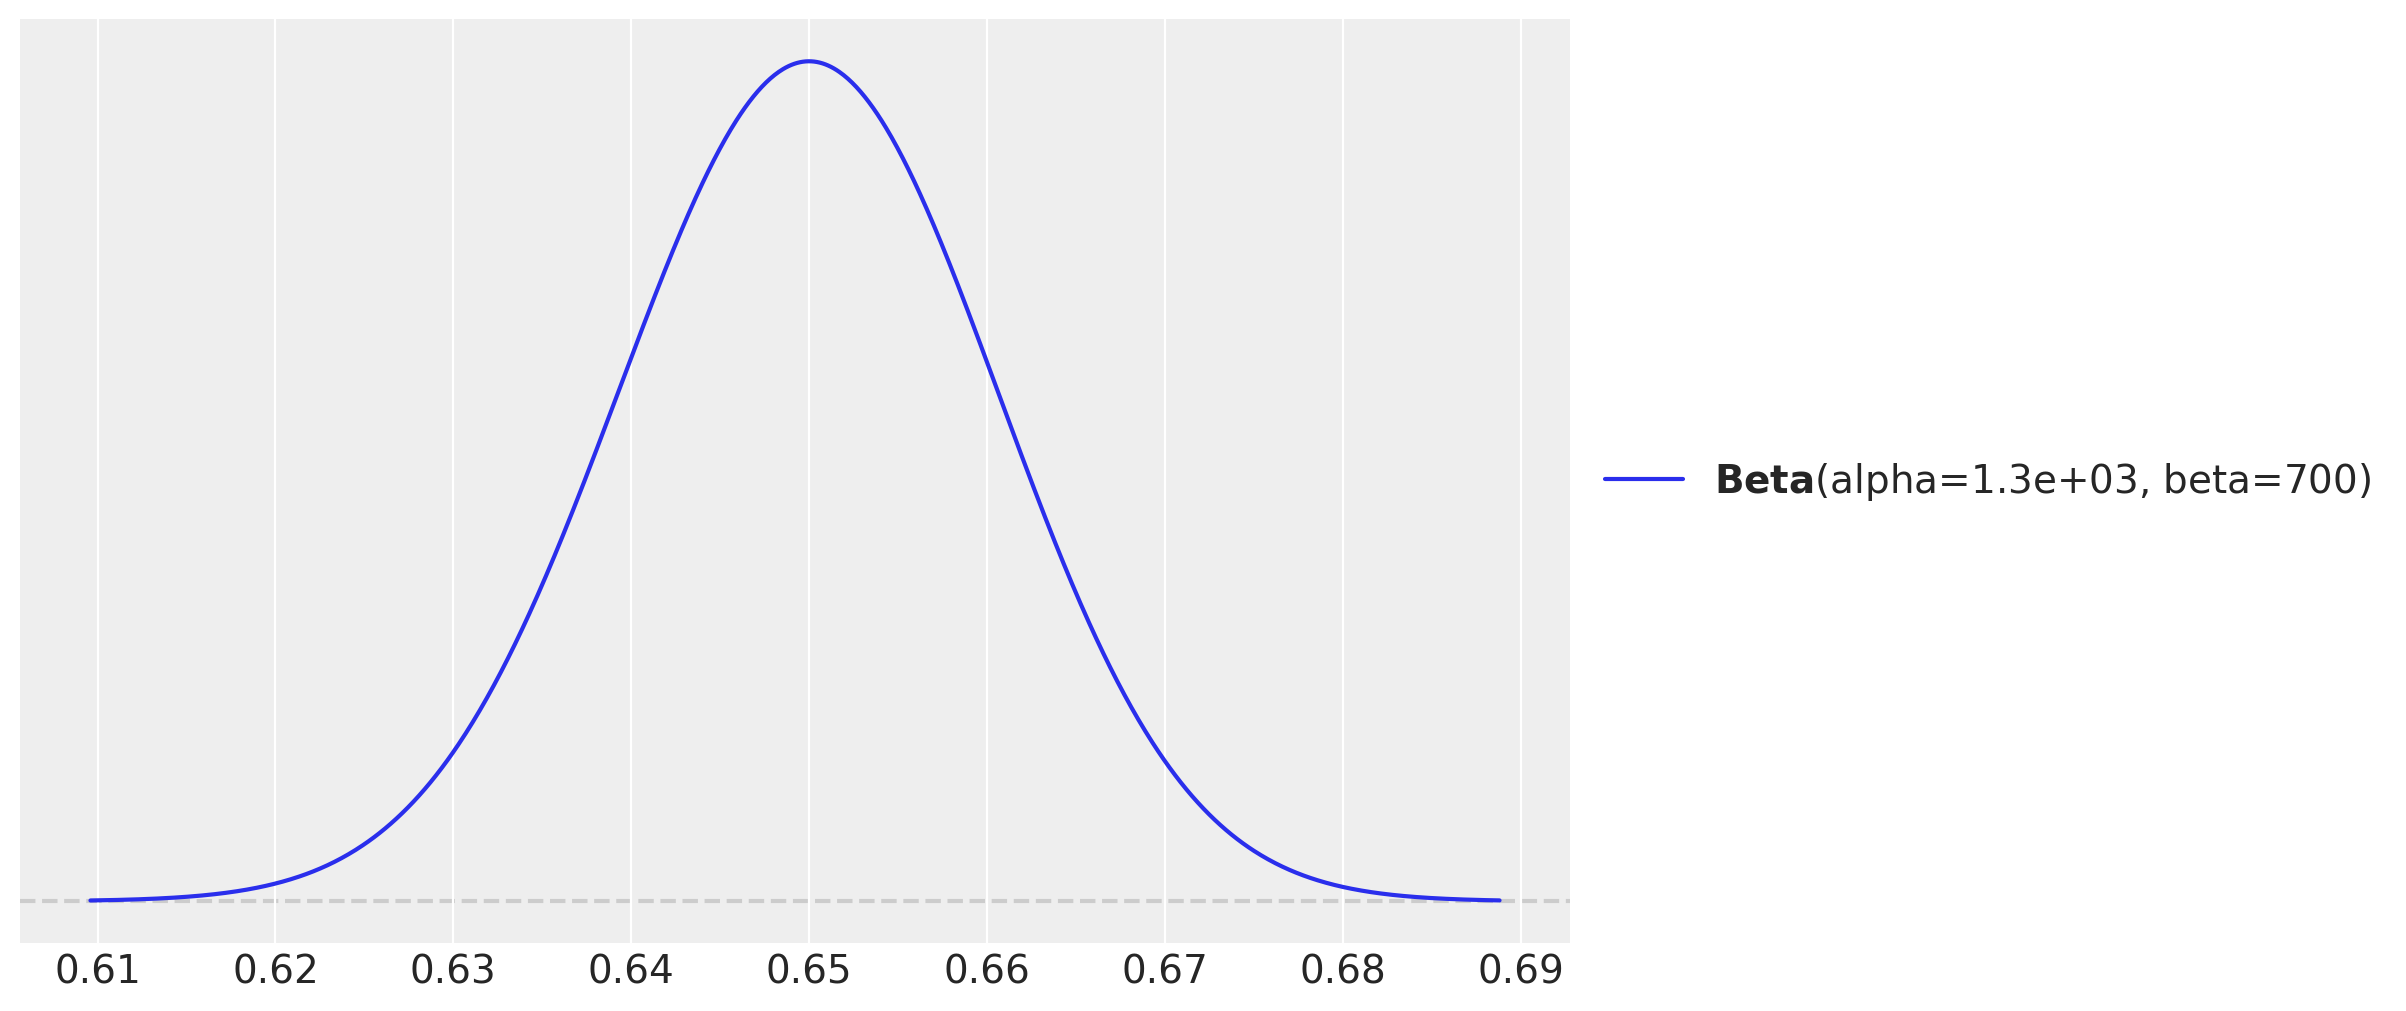

In [130]:
fig, ax = plt.subplots()
omega = 0.65
pz.Beta(alpha=omega * (2_000 - 2) + 1, beta=(1 - omega) * (2_000 - 2) + 1).plot_pdf(
    ax=ax
)


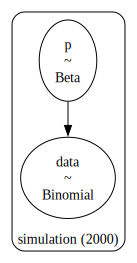

In [131]:
n_simulations = 2_000
n = 150

with pm.Model(coords={"simulation": range(n_simulations)}) as data_generating_model:
    omega = 0.65
    p = pm.Beta(
        "p",
        alpha=omega * (2_000 - 2) + 1,
        beta=(1 - omega) * (2_000 - 2) + 1,
        dims="simulation",
    )
    pm.Binomial("data", n=n, p=p, dims=("simulation",))

pm.model_to_graphviz(data_generating_model)


In [132]:
with data_generating_model:
    generating_model_idata = pm.sample_prior_predictive(samples=1, random_seed=rng)

generated_data = generating_model_idata["prior"]["data"].sel(chain=0, draw=0).to_numpy()

generated_data


Sampling: [data, p]


array([101,  90,  96, ...,  96, 108,  87])

<Axes: >

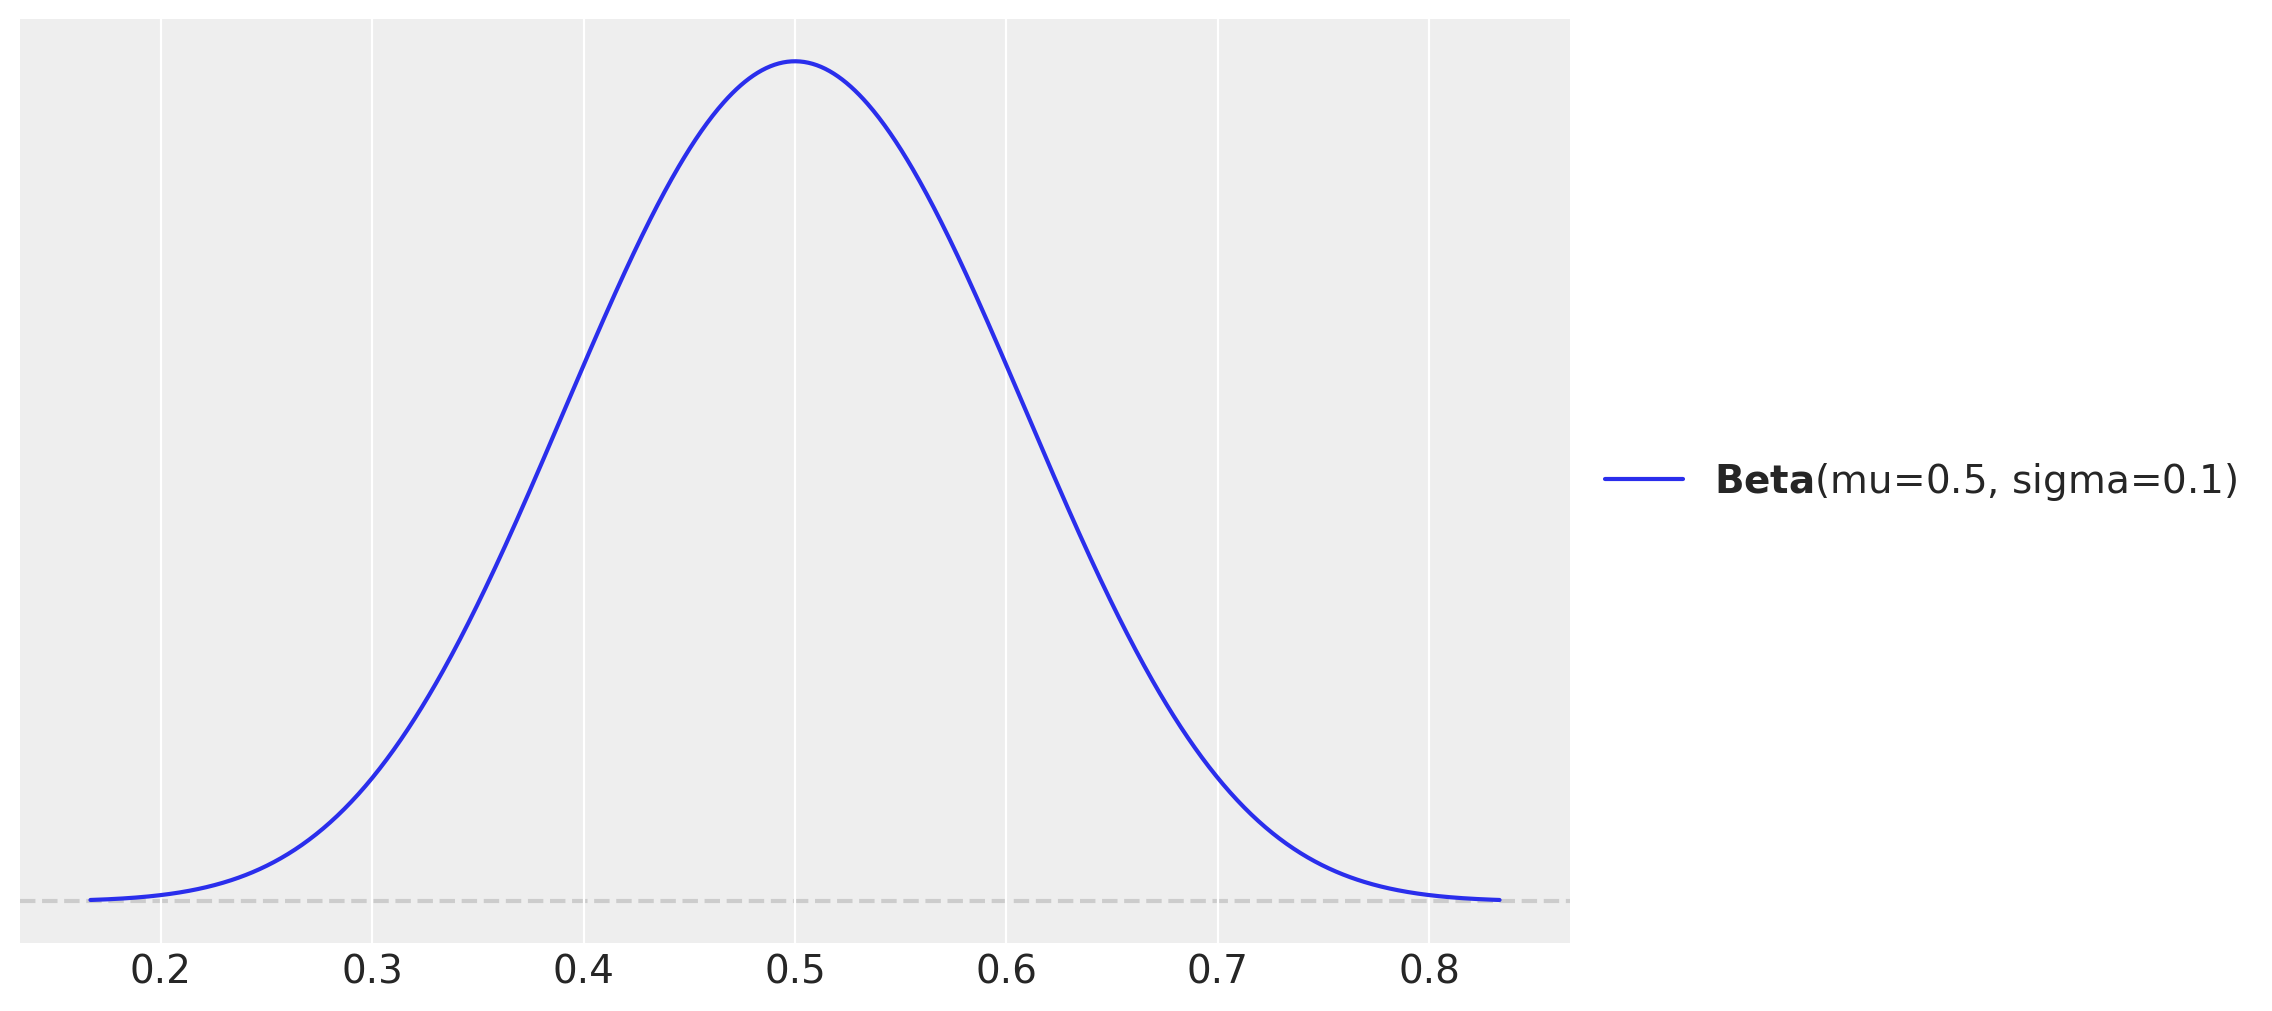

In [133]:
fig, ax = plt.subplots()
pz.Beta(mu=0.5, sigma=0.1).plot_pdf(ax=ax)

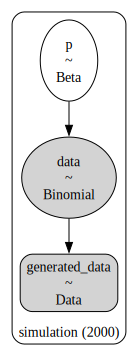

In [134]:
with pm.Model(coords={"simulation": range(n_simulations)}) as model:
    generated_data_ = pm.Data("generated_data", generated_data, dims=("simulation",))
    p = pm.Beta("p", mu=0.5, sigma=0.1, dims="simulation")
    pm.Binomial("data", n=n, p=p, observed=generated_data_, dims=("simulation",))

pm.model_to_graphviz(model)

In [135]:
with model:
    idata = pm.sample(random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [136]:
az.summary(idata["posterior"].sel(simulation=slice(None, 10)), var_names=["p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.648,0.036,0.583,0.719,0.0,0.001,6455.0,2637.0,1.0
p[1],0.586,0.038,0.511,0.655,0.0,0.001,7025.0,2809.0,1.0
p[2],0.621,0.036,0.553,0.688,0.0,0.001,6876.0,2408.0,1.0
p[3],0.620,0.036,0.552,0.688,0.0,0.001,6456.0,2828.0,1.0
p[4],0.649,0.036,0.580,0.714,0.0,0.001,7976.0,2856.0,1.0
p[5],0.626,0.035,0.559,0.693,0.0,0.001,7446.0,2882.0,1.0
p[6],0.678,0.036,0.611,0.747,0.0,0.001,6912.0,2616.0,1.0
p[7],0.632,0.036,0.564,0.699,0.0,0.001,6505.0,2754.0,1.0
p[8],0.621,0.036,0.557,0.691,0.0,0.001,7237.0,2384.0,1.0
p[9],0.644,0.037,0.573,0.712,0.0,0.001,6490.0,2786.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

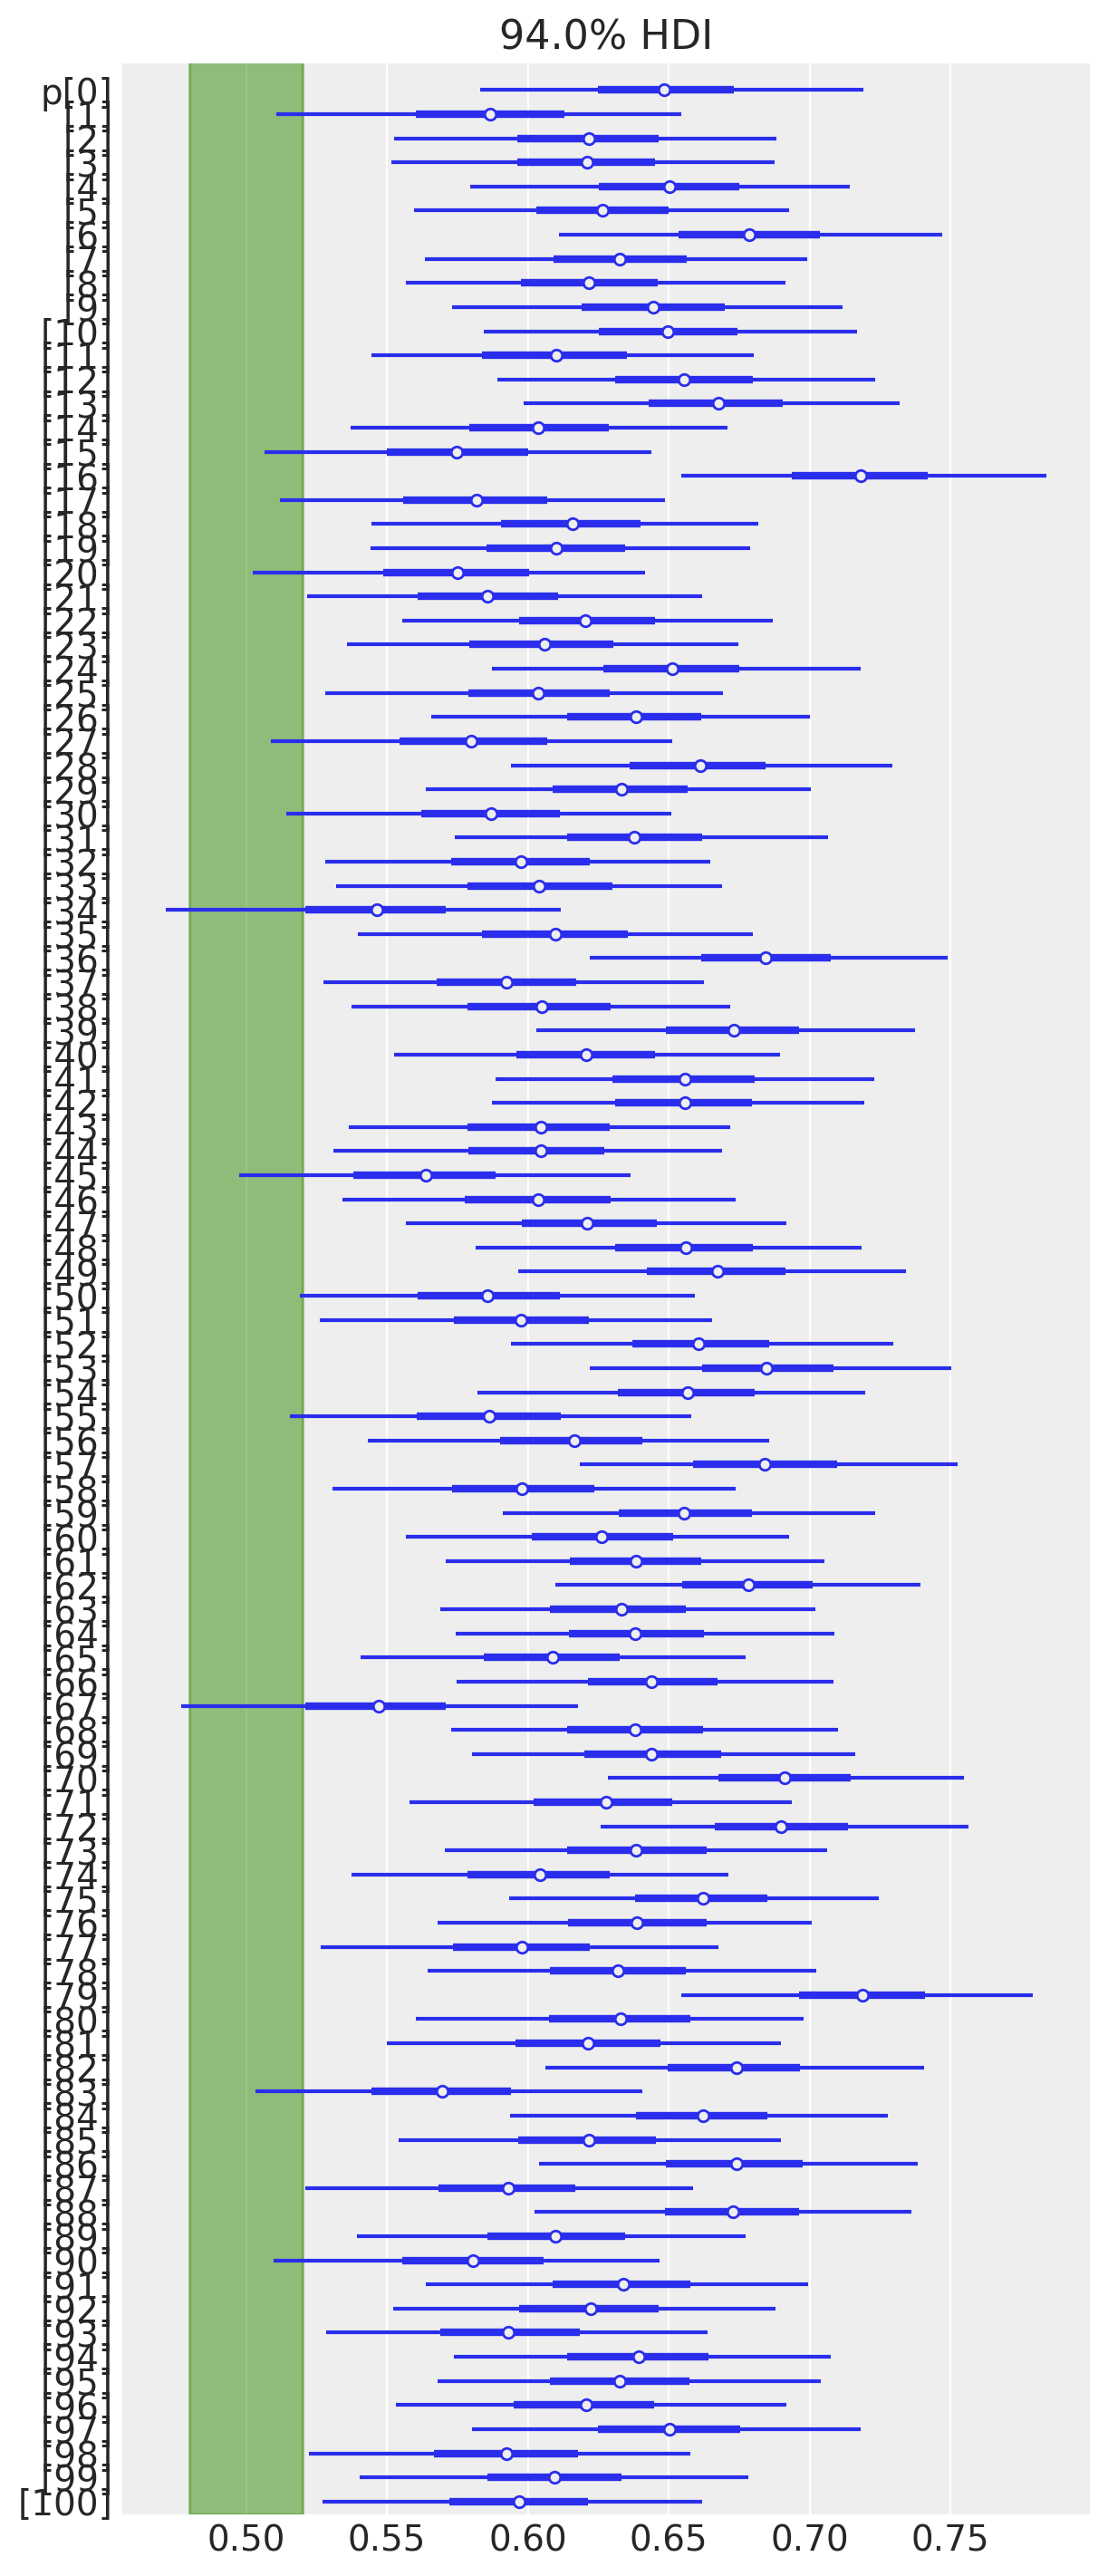

In [137]:
az.plot_forest(
    idata["posterior"].sel(simulation=slice(None, 100)),
    var_names=["p"],
    combined=True,
    rope=[0.48, 0.52],
)

In [138]:
(az.hdi(idata["posterior"], hdi_prob=0.94)["p"].sel(hdi="lower") > 0.52).mean().item()

0.866